In [1]:
import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection

In [2]:
cifar10.data_path = "/home/venom/Desktop/Untitled Folder/lec 20"

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [51]:
images, cls, ohe = cifar10.load_training_data()
images,_1, ohe, _2 =  model_selection.train_test_split(images, ohe, test_size= 0.80)

images_, cls_, ohe_ = cifar10.load_test_data()
images_,_1, ohe_, _2 =  model_selection.train_test_split(images_, ohe_, test_size= 0.80)

images.shape

Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/data_batch_1
Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/data_batch_2
Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/data_batch_3
Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/data_batch_4
Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/data_batch_5
Loading data: /home/venom/Desktop/Untitled Folder/lec 20/cifar-10-batches-py/test_batch


(10000, 32, 32, 3)

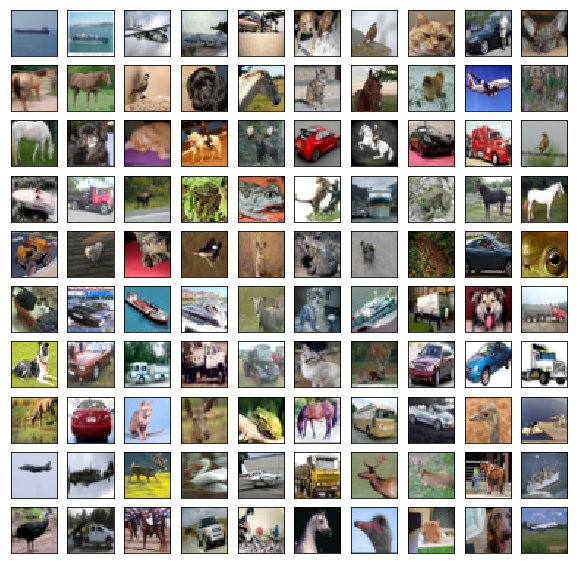

In [30]:
fig = plt.figure(figsize=(10, 10))

for i in range(100) :
    ax = fig.add_subplot(10, 10, i + 1, xticks = [], yticks = [])
    ax.imshow(images[i], cmap = plt.cm.bone)

plt.show()

In [54]:
input_width = 32
input_height = 32
input_channels = 3
n_input = 1024
n_conv1 = 512
n_conv2 = 512
conv1_k = 5
conv2_k = 5
n_hidden = 128
n_out = 10
pooling_window_size = 2

In [55]:
weights = {
    "wc1" : tf.Variable(tf.random_normal([conv1_k, conv1_k ,input_channels, n_conv1])),
    "wc2" : tf.Variable(tf.random_normal([conv2_k, conv2_k ,n_conv1, n_conv2])),
    "wh1" : tf.Variable(tf.random_normal([input_width//4 * input_height//4 * n_conv2, n_hidden])),
    "wout": tf.Variable(tf.random_normal([n_hidden, n_out]))
}

biases = {
    "bc1" : tf.Variable(tf.random_normal([n_conv1])),
    "bc2" : tf.Variable(tf.random_normal([n_conv2])),
    "bh1" : tf.Variable(tf.random_normal([n_hidden])),
    "bout": tf.Variable(tf.random_normal([n_out]))
}

In [56]:
def conv(x, weights, bias, strides = 1):
    out = tf.nn.conv2d(x, weights, padding="SAME", strides=[1, strides, strides, 1])
    out = tf.nn.bias_add(out, bias)
    return tf.nn.relu(out)

def maxpooling(x, k = 2):
    return tf.nn.max_pool(x, padding="SAME", ksize=[1, k, k, 1], strides=[1, k, k, 1])

In [57]:
def cnn(x, weights, biases):
    x = tf.reshape(x, shape = [-1,input_height, input_width, 3])
    conv1 = conv(x, weights["wc1"], biases["bc1"])
    conv1 = maxpooling(conv1, k = pooling_window_size)
    
    conv2 = conv(conv1, weights["wc2"], biases["bc2"])
    conv2 = maxpooling(conv2, k = pooling_window_size)
    
    hidden_input = tf.reshape(conv2, shape=[-1, input_width//4 * input_height//4 * n_conv2])
    hidden_output = tf.add(tf.matmul(hidden_input, weights["wh1"]), biases['bh1'])
    hidden_output = tf.nn.relu(hidden_output)
    
    out =  tf.add(tf.matmul(hidden_output, weights["wout"]), biases['bout'])
    return out

In [58]:
x = tf.placeholder("float", [None, 32, 32, 3])
y = tf.placeholder("float", [None, n_out])
pred = cnn(x, weights, biases)

In [61]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [62]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
images.shape
ohe

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [63]:
batch_size = 1000
for i in range(15):
    num_batches = int(images.shape[0]/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x, batch_y = images[j*batch_size:(j+1)*batch_size], ohe[j*batch_size:(j+1)*batch_size]
        _ , c = sess.run([optimize, cost], feed_dict={x:batch_x, y:batch_y})
        total_cost += c
    print(total_cost)

KeyboardInterrupt: 

7.1593761444091797

In [52]:
predictions = tf.argmax(pred, 1)
correct_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, correct_labels)
predictions,correct_predictions  = sess.run([predictions, correct_predictions], feed_dict={x:images_,
                                              y:ohe_})

In [53]:
(correct_predictions == False).sum()

1786